In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [343]:
path = '/Users/yuqingdai/Documents/GitHub/Stock-Erdos/scratch work/Yuqing-Data-Merge/data/dt/df.csv'

In [344]:
df1= pd.read_csv(path, parse_dates=['ds'])
df1 = df1.rename(columns = {"Date":"ds","Close":"y"}) 
df1

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yuqingdai/Documents/GitHub/Stock-Erdos/scratch work/Yuqing-Data-Merge/data/dt/df.csv'

In [336]:
df1= pd.read_csv(path, parse_dates=['ds'])
# df1 = df1.rename(columns = {"Date":"ds","Close":"y"}) 
df1 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yuqingdai/Documents/GitHub/Stock-Erdos/scratch work/Yuqing-Data-Merge/data/dt/df.csv'

In [337]:
import datetime as datetime
ctf_date = datetime.datetime(2020, 3, 1)
df = df1.loc[df1.ds < ctf_date , ].copy()
# df = df1.copy()
df 

,ds,y,tby,ffr,fta,eps,div,une,wti,ppi,rfs
0,2003-01-02,909.03,4.07,1.24,732202.0,40.40,1.79,5.8,31.97,135.3,295248.0
1,2003-01-03,908.59,4.05,1.24,732202.0,40.40,1.79,5.8,33.26,135.3,295248.0
2,2003-01-06,929.01,4.09,1.24,732202.0,40.40,1.79,5.8,32.29,135.3,295248.0
3,2003-01-07,922.93,4.04,1.24,732202.0,40.40,1.79,5.8,31.20,135.3,295248.0
4,2003-01-08,909.93,4.00,1.24,724902.0,40.40,1.79,5.8,30.66,135.3,295248.0
...,...,...,...,...,...,...,...,...,...,...,...
4285,2020-02-24,3225.89,1.38,1.58,4171570.0,135.28,1.79,3.5,51.36,196.7,525810.0
4286,2020-02-25,3128.21,1.33,1.58,4171570.0,135.28,1.79,3.5,49.78,196.7,525810.0
4287,2020-02-26,3116.39,1.33,1.58,4158637.0,135.28,1.79,3.5,48.67,196.7,525810.0
4288,2020-02-27,2978.76,1.30,1.58,4158637.0,135.28,1.79,3.5,47.17,196.7,525810.0


In [338]:
pred_periods = 252
p = 0.9
tmp_pred_periods= 100

In [339]:
num_winds = int(pred_periods * (p*10)//100 + 1)
start = len(df) - num_winds *tmp_pred_periods - pred_periods
cutoff = start + num_winds * tmp_pred_periods

print(num_winds, cutoff, cutoff-start )

23 4038 2300


In [340]:
df_train = df[:cutoff].copy()
df_test = df.drop(df_train.index).copy()

In [305]:
#prophet part 
from fbprophet import Prophet
pro_pred = []

# use accumulated data to predict the next pred_size data
for i in range(num_winds):
    end = start+ i*tmp_pred_periods
    
    tmp_train = df_train.iloc[: end].copy()
    
    fbp = Prophet(daily_seasonality=True) 
    # fit close price using fbprophet model
    fbp.fit(tmp_train[['ds','y']])
    
    # predict pred_size futures and get the forecast price 
    fut = fbp.make_future_dataframe(periods = tmp_pred_periods)
    tmp_forecast = fbp.predict(fut) 
    if (i == 0):
        pro_pred.append(tmp_forecast[:start].yhat)
      
    # only require the forcast on test data of temporary training data
    pred = tmp_forecast[end:].yhat
    pro_pred.append(pred)

In [295]:
# pro_pred

In [308]:
# flat the pro_pred
flat_pro_pred = [item for l1 in pro_pred for item in l1]

In [309]:
df_train['fbsp'] = pd.Series(flat_pro_pred)

In [310]:
from fbprophet import Prophet
fbp = Prophet(daily_seasonality=True)

# fit close price using fbprophet model
fbp.fit(df_train[['ds','y']])
    
 # predict pred_size futures and get the forecast price 
fut = fbp.make_future_dataframe(periods = pred_periods, freq='D')
forecast = fbp.predict(fut) 

In [311]:
df_test['fbsp'] = forecast.loc[cutoff:, 'yhat']
df_test

,ds,y,tby,ffr,fta,eps,div,une,wti,ppi,rfs,fbsp
4268,2020-01-29,3273.40,1.60,1.55,4151630.0,143.76,1.83,3.5,53.29,199.3,526930.0,3118.898812
4269,2020-01-30,3283.66,1.57,1.55,4151630.0,143.76,1.83,3.5,52.19,199.3,526930.0,3119.048145
4270,2020-01-31,3225.52,1.51,1.55,4151630.0,135.28,1.79,3.5,51.58,199.3,526930.0,3118.621657
4271,2020-02-03,3248.92,1.54,1.58,4151630.0,135.28,1.79,3.5,50.06,196.7,525810.0,3125.763077
4272,2020-02-04,3297.59,1.61,1.58,4151630.0,135.28,1.79,3.5,49.59,196.7,525810.0,3125.725321
...,...,...,...,...,...,...,...,...,...,...,...,...
4515,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,52.78,204.3,576466.0,3297.190073
4516,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,52.61,204.3,576466.0,3303.660102
4517,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,52.81,204.3,576466.0,3302.833411
4518,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58,6.3,52.26,204.3,576466.0,3293.411574


In [312]:
fc_df = pd.DataFrame(data={'ds': df.ds.to_numpy().ravel(), 'fbsp': forecast.yhat})
# fc_df

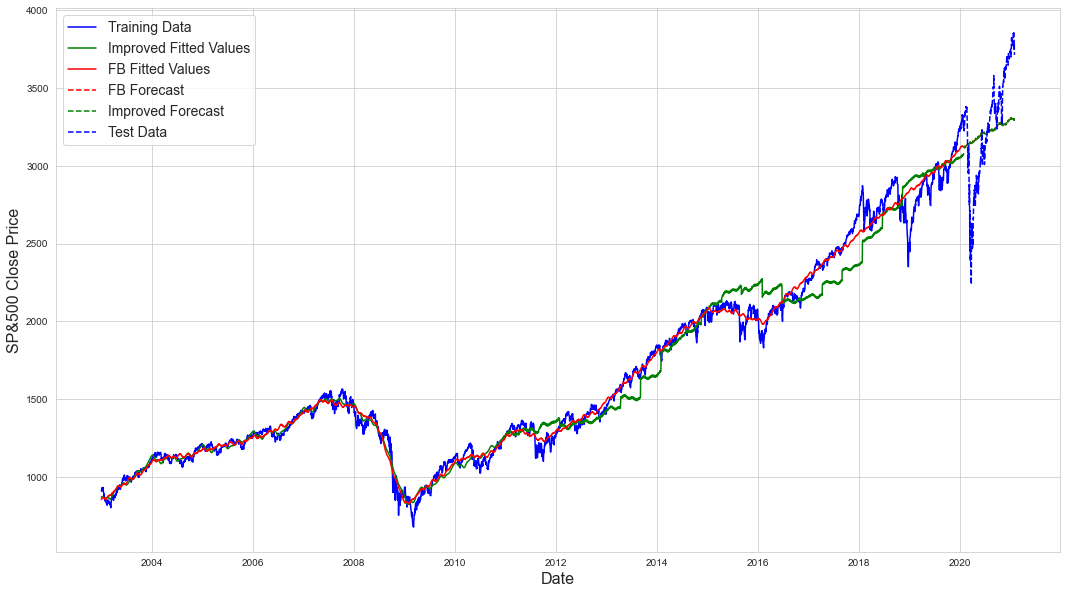

In [313]:
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b', label = "Training Data")

plt.plot(df_train.ds,df_train.fbsp,'g-', label = "Improved Fitted Values")

# plot the fit
plt.plot(df_train.ds, fc_df[:cutoff].fbsp,'r-', label = "FB Fitted Values")

# plot the forecast
plt.plot(df_test.ds, fc_df[cutoff:].fbsp,'r--', label = "FB Forecast")
plt.plot(df_test.ds,  df_test.fbsp,'g--',label = "Improved Forecast")
plt.plot(df_test.ds, df_test.y,'b--', label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()

In [314]:
df2 = df.copy()
df2['fbsp'] = pd.concat([df_train,df_test]).fbsp
df2['diff'] = df2['y'] - df2['fbsp']

In [315]:
df2 = df2.dropna()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2.set_index(df2['ds'])
df2 = df2.drop(columns=['ds'])

In [316]:
df3 = df2.loc[df2.index[start]:,].copy()
df3

,y,tby,ffr,fta,eps,div,une,wti,ppi,rfs,fbsp,diff
ds,,,,,,,,,,,,
2010-11-16,1178.34,2.85,0.19,2312859.0,89.24,1.92,9.8,82.33,187.7,367455.0,1217.104758,-38.764758
2010-11-17,1178.59,2.89,0.19,2314851.0,89.24,1.92,9.8,80.43,187.7,367455.0,1217.501108,-38.911108
2010-11-18,1196.69,2.90,0.19,2314851.0,89.24,1.92,9.8,81.88,187.7,367455.0,1218.488352,-21.798352
2010-11-19,1199.73,2.88,0.19,2314851.0,89.24,1.92,9.8,81.65,187.7,367455.0,1218.660233,-18.930233
2010-11-22,1197.84,2.80,0.19,2314851.0,89.24,1.92,9.8,81.24,187.7,367455.0,1229.440823,-31.600823
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,52.78,204.3,576466.0,3297.190073,558.169927
2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,52.61,204.3,576466.0,3303.660102,545.959898
2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,52.81,204.3,576466.0,3302.833411,447.936589


In [317]:
df3.to_csv(r'/Users/yuqingdai/Documents/GitHub/Stock-Erdos/Data/dff2.csv')